# K-fold crossvalidation

This notebook uses k-fold (5-folds) crossvalidation to evaluate the performance of different models.\
The validation sets are 20% splits of the natural biotite composition database from Pattison and Forshaw (in prep).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from keras.models import load_model

from ml_tb.normalisation import MinMaxScaler
from ml_tb.metrics import RMSE_denormalised_P, RMSE_denormalised_T, RMSE_denormalised_temperature_only
from ml_tb.validation import load_k_models, predict_on_val_set, RMSE, kfold_RMSE_PT, kfold_RMSE_T, RMSE_temperature_ranges, RMSE_ranges

## Load validation datasets

In [2]:
files = ["test_data_0.csv", "test_data_1.csv", "test_data_2.csv", "test_data_3.csv", "test_data_4.csv"]
DIR = Path("..", "01_fit_natural_biotite", "kfold_datasets")

val_data_TiXMg = []
val_t_TiXMg = []

val_data_MnFMAST = []
val_pt_MnFMAST = []

val_data_MnFMAST_index = []
val_pt_MnFMAST_index = []

for file in files:
    data = np.loadtxt(DIR / file, delimiter=",")

    # Extract the corresponding data
    val_data_TiXMg.append(data[:, [1, 6]])
    val_t_TiXMg.append(data[:, -1])

    val_data_MnFMAST.append(data[:, 0:6])
    val_pt_MnFMAST.append(data[:, -2:])

    val_data_MnFMAST_index.append(np.concatenate((data[:, 0:6], data[:, 7:-2]), axis=1))
    val_pt_MnFMAST_index.append(data[:, -2:])

## Load models

In [3]:
# define the custom metrics
scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0)
inv_scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0, invert=True)

scaling_t = MinMaxScaler(min=400, max=900, axis=0)
inv_scaling_t = MinMaxScaler(min=400, max=900, axis=0, invert=True)

def RMSE_P(y_true, y_pred):
    return RMSE_denormalised_P(y_true, y_pred, inv_scaling_pt)

def RMSE_T(y_true, y_pred):
    return RMSE_denormalised_T(y_true, y_pred, inv_scaling_pt)

def RMSE_T_only(y_true, y_pred):
    return RMSE_denormalised_temperature_only(y_true, y_pred, inv_scaling_t)

In [4]:
models_TiXMg = load_k_models("AA_k_TiXMg", Path("01_fit_natural_biotite", "saved_models"), [RMSE_T_only])
models_MnFMAST = load_k_models("AA_k_MnFMAST", Path("01_fit_natural_biotite", "saved_models"), [RMSE_T, RMSE_P])
models_MnFMAST_index = load_k_models("AA_k_MnFMAST_index", Path("01_fit_natural_biotite", "saved_models"), [RMSE_T, RMSE_P])

models_ds62 = load_k_models("model_ds62White2014", Path("02_pretraining", "saved_models"), [RMSE_T, RMSE_P], k_models=False)
models_ds55Bt07 = load_k_models("model_ds55White2007", Path("02_pretraining", "saved_models"), [RMSE_T, RMSE_P], k_models=False)
models_ds55BtT = load_k_models("model_ds55Tajcmanova2009", Path("02_pretraining", "saved_models"), [RMSE_T, RMSE_P], k_models=False)

models_transfers_ds62 = load_k_models("k_ds62", Path("03_transfer_learning", "saved_models"), [RMSE_T, RMSE_P])
models_transfers_ds55Bt07 = load_k_models("k_ds55Bt07", Path("03_transfer_learning", "saved_models"), [RMSE_T, RMSE_P])
models_transfers_ds55BtT = load_k_models("k_ds55BtT", Path("03_transfer_learning", "saved_models"), [RMSE_T, RMSE_P])

## Predict on validation sets

In [5]:
y_pred_TiXMg = predict_on_val_set(models_TiXMg, val_data_TiXMg, inv_scaling_t)
y_pred_MnFMAST = predict_on_val_set(models_MnFMAST, val_data_MnFMAST, inv_scaling_pt)
y_pred_MnFMAST_index = predict_on_val_set(models_MnFMAST_index, val_data_MnFMAST_index, inv_scaling_pt)

y_pred_ds62 = predict_on_val_set(models_ds62, val_data_MnFMAST, inv_scaling_pt)
y_pred_ds55Bt07 = predict_on_val_set(models_ds55Bt07, val_data_MnFMAST, inv_scaling_pt)
y_pred_ds55BtT = predict_on_val_set(models_ds55BtT, val_data_MnFMAST, inv_scaling_pt)

y_pred_ds62_transfer = predict_on_val_set(models_transfers_ds62, val_data_MnFMAST, inv_scaling_pt)
y_pred_ds55Bt07_transfer = predict_on_val_set(models_transfers_ds55Bt07, val_data_MnFMAST, inv_scaling_pt)
y_pred_ds55BtT_transfer = predict_on_val_set(models_transfers_ds55BtT, val_data_MnFMAST, inv_scaling_pt)

14/14 [==============================] - 0s 341us/step


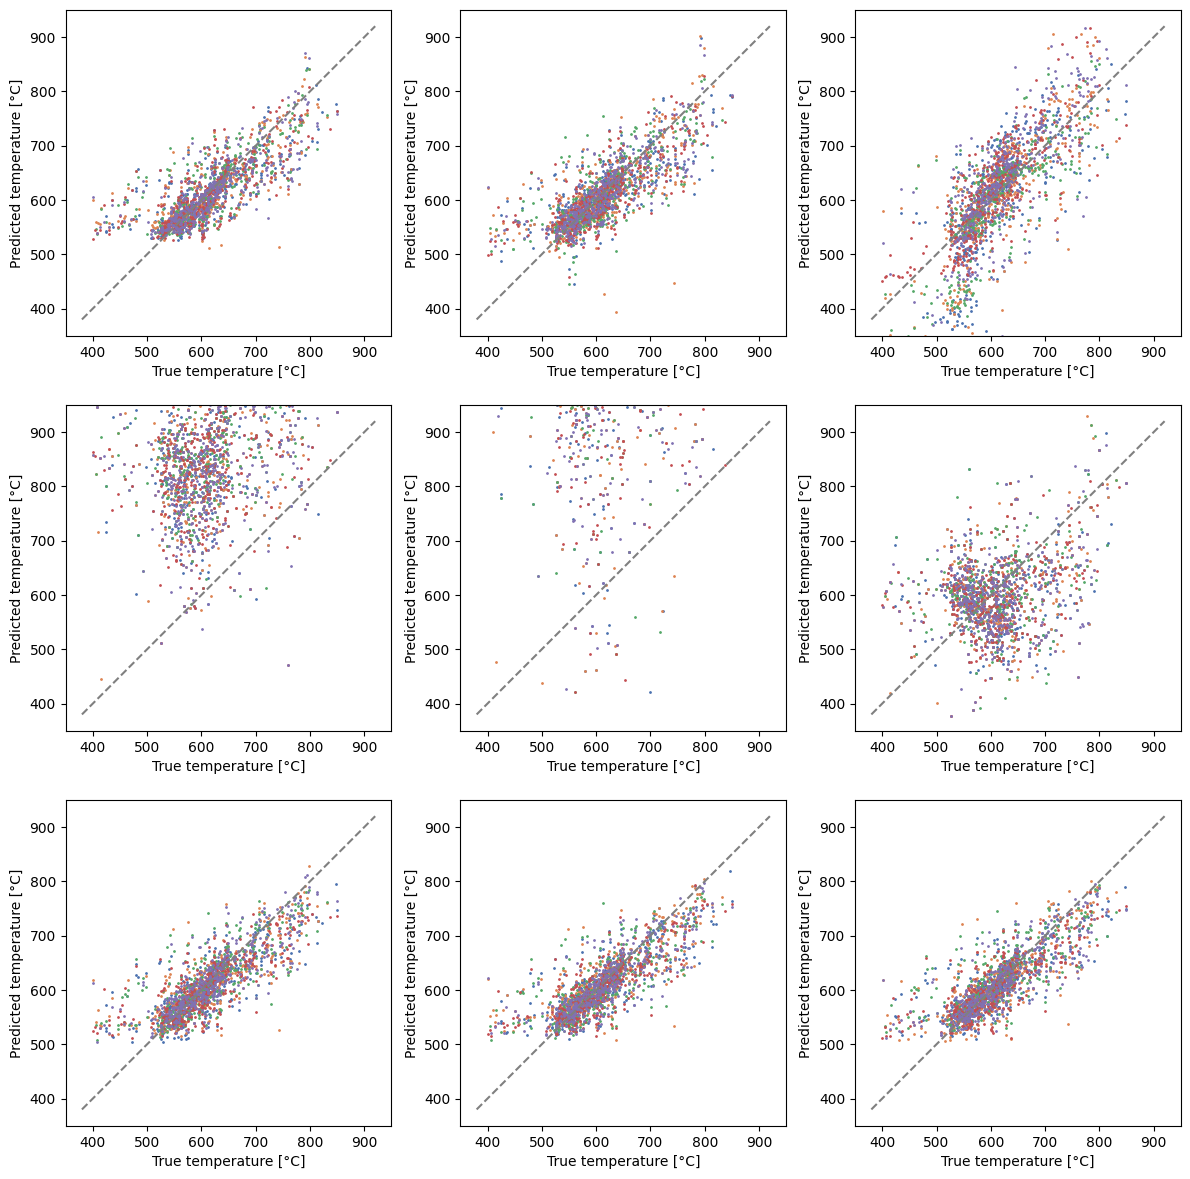

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

colors = sns.color_palette("deep", 5)

axs[0, 0].plot([380, 920], [380, 920], color="grey", linestyle="--", lw=1.5)
for i in range(len(val_t_TiXMg)):
    axs[0, 0].scatter(val_t_TiXMg[i], y_pred_TiXMg[i], s=1, color=colors[i])

axs[0, 0].set_aspect('equal')
axs[0, 0].set_xlim(350, 950)
axs[0, 0].set_ylim(350, 950)
axs[0, 0].set_xlabel('True temperature [°C]')
axs[0, 0].set_ylabel('Predicted temperature [°C]')

axs[0, 1].plot([380, 920], [380, 920], color="grey", linestyle="--", lw=1.5)
for i in range(len(val_pt_MnFMAST)):
    axs[0, 1].scatter(val_pt_MnFMAST[i][:, 1], y_pred_MnFMAST[i][:, 1], s=1, color=colors[i])

axs[0, 1].set_aspect('equal')
axs[0, 1].set_xlim(350, 950)
axs[0, 1].set_ylim(350, 950)
axs[0, 1].set_xlabel('True temperature [°C]')
axs[0, 1].set_ylabel('Predicted temperature [°C]')

axs[0, 2].plot([380, 920], [380, 920], color="grey", linestyle="--", lw=1.5)
for i in range(len(val_pt_MnFMAST_index)):
    axs[0, 2].scatter(val_pt_MnFMAST_index[i][:, 1], y_pred_MnFMAST_index[i][:, 1], s=1, color=colors[i])

axs[0, 2].set_aspect('equal')
axs[0, 2].set_xlim(350, 950)
axs[0, 2].set_ylim(350, 950)
axs[0, 2].set_xlabel('True temperature [°C]')
axs[0, 2].set_ylabel('Predicted temperature [°C]')

axs[1, 0].plot([380, 920], [380, 920], color="grey", linestyle="--", lw=1.5)
for i in range(len(val_pt_MnFMAST)):
    axs[1, 0].scatter(val_pt_MnFMAST[i][:, 1], y_pred_ds62[i][:, 1], s=1, color=colors[i])

axs[1, 0].set_aspect('equal')
axs[1, 0].set_xlim(350, 950)
axs[1, 0].set_ylim(350, 950)
axs[1, 0].set_xlabel('True temperature [°C]')
axs[1, 0].set_ylabel('Predicted temperature [°C]')

axs[1, 1].plot([380, 920], [380, 920], color="grey", linestyle="--", lw=1.5)
for i in range(len(val_pt_MnFMAST)):
    axs[1, 1].scatter(val_pt_MnFMAST[i][:, 1], y_pred_ds55Bt07[i][:, 1], s=1, color=colors[i])

axs[1, 1].set_aspect('equal')
axs[1, 1].set_xlim(350, 950)
axs[1, 1].set_ylim(350, 950)
axs[1, 1].set_xlabel('True temperature [°C]')
axs[1, 1].set_ylabel('Predicted temperature [°C]')

axs[1, 2].plot([380, 920], [380, 920], color="grey", linestyle="--", lw=1.5)
for i in range(len(val_pt_MnFMAST)):
    axs[1, 2].scatter(val_pt_MnFMAST[i][:, 1], y_pred_ds55BtT[i][:, 1], s=1, color=colors[i])

axs[1, 2].set_aspect('equal')
axs[1, 2].set_xlim(350, 950)
axs[1, 2].set_ylim(350, 950)
axs[1, 2].set_xlabel('True temperature [°C]')
axs[1, 2].set_ylabel('Predicted temperature [°C]')

axs[2, 0].plot([380, 920], [380, 920], color="grey", linestyle="--", lw=1.5)
for i in range(len(val_pt_MnFMAST)):
    axs[2, 0].scatter(val_pt_MnFMAST[i][:, 1], y_pred_ds62_transfer[i][:, 1], s=1, color=colors[i])

axs[2, 0].set_aspect('equal')
axs[2, 0].set_xlim(350, 950)
axs[2, 0].set_ylim(350, 950)
axs[2, 0].set_xlabel('True temperature [°C]')
axs[2, 0].set_ylabel('Predicted temperature [°C]')

axs[2, 1].plot([380, 920], [380, 920], color="grey", linestyle="--", lw=1.5)
for i in range(len(val_pt_MnFMAST)):
    axs[2, 1].scatter(val_pt_MnFMAST[i][:, 1], y_pred_ds55Bt07_transfer[i][:, 1], s=1, color=colors[i])

axs[2, 1].set_aspect('equal')
axs[2, 1].set_xlim(350, 950)
axs[2, 1].set_ylim(350, 950)
axs[2, 1].set_xlabel('True temperature [°C]')
axs[2, 1].set_ylabel('Predicted temperature [°C]')

axs[2, 2].plot([380, 920], [380, 920], color="grey", linestyle="--", lw=1.5)
for i in range(len(val_pt_MnFMAST)):
    axs[2, 2].scatter(val_pt_MnFMAST[i][:, 1], y_pred_ds55BtT_transfer[i][:, 1], s=1, color=colors[i])

axs[2, 2].set_aspect('equal')
axs[2, 2].set_xlim(350, 950)
axs[2, 2].set_ylim(350, 950)
axs[2, 2].set_xlabel('True temperature [°C]')
axs[2, 2].set_ylabel('Predicted temperature [°C]')

fig.tight_layout()

/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_38612/1029733498.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot([RMSE_T_TiXMg, RMSE_T_MnFMAST, RMSE_T_MnFMAST_index, RMSE_T_ds62_transfer, RMSE_T_ds55Bt07_transfer, RMSE_T_ds55BtT_transfer], labels=["TiXMg", "MnFMAST", "MnFMAST_index", "ds62_transfer", "ds55Bt07_transfer", "ds55BtT_transfer"])
/var/folders/4p/0crcpfgd00x_wz_bsvpnhpqw0000gn/T/ipykernel_38612/1029733498.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([RMSE_P_MnFMAST, RMSE_P_MnFMAST_index, RMSE_P_ds62_transfer, RMSE_P_ds55Bt07_transfer, RMSE_P_ds55BtT_transfer], labels=["MnFMAST", "MnFMAST_index", "ds62_transfer", "ds55Bt07_transfer", "ds55BtT_transfer"])


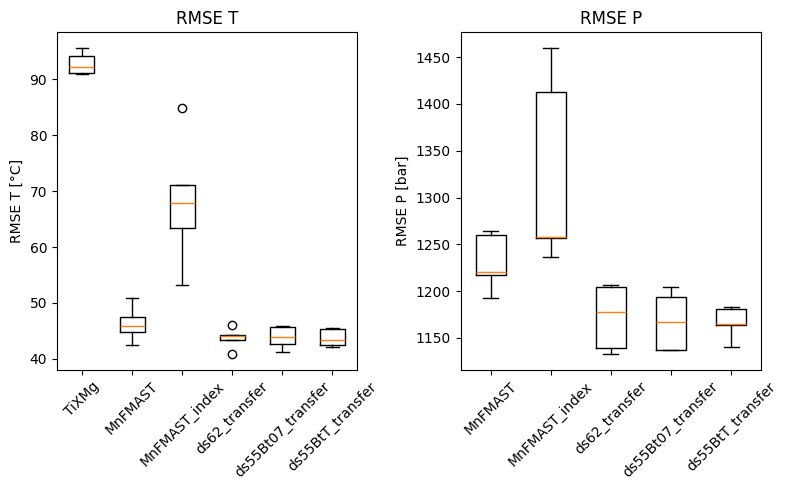

In [7]:
# clalculate RMSE P and T for each model set
RMSE_T_TiXMg = kfold_RMSE_T(val_t_TiXMg, y_pred_TiXMg)
RMSE_P_MnFMAST, RMSE_T_MnFMAST = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_MnFMAST)
RMSE_P_MnFMAST_index, RMSE_T_MnFMAST_index = kfold_RMSE_PT(val_pt_MnFMAST_index, y_pred_MnFMAST_index)

RMSE_P_ds62, RMSE_T_ds62 = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds62)
RMSE_P_ds55Bt07, RMSE_T_ds55Bt07 = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds55Bt07)
RMSE_P_ds55BtT, RMSE_T_ds55BtT = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds55BtT)

RMSE_P_ds62_transfer, RMSE_T_ds62_transfer = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds62_transfer)
RMSE_P_ds55Bt07_transfer, RMSE_T_ds55Bt07_transfer = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds55Bt07_transfer)
RMSE_P_ds55BtT_transfer, RMSE_T_ds55BtT_transfer = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds55BtT_transfer)


# plot the RMSE for each model set
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

axs[0].boxplot([RMSE_T_TiXMg, RMSE_T_MnFMAST, RMSE_T_MnFMAST_index, RMSE_T_ds62_transfer, RMSE_T_ds55Bt07_transfer, RMSE_T_ds55BtT_transfer], labels=["TiXMg", "MnFMAST", "MnFMAST_index", "ds62_transfer", "ds55Bt07_transfer", "ds55BtT_transfer"])
axs[0].set_ylabel("RMSE T [°C]")
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45)
axs[0].set_title("RMSE T")

axs[1].boxplot([RMSE_P_MnFMAST, RMSE_P_MnFMAST_index, RMSE_P_ds62_transfer, RMSE_P_ds55Bt07_transfer, RMSE_P_ds55BtT_transfer], labels=["MnFMAST", "MnFMAST_index", "ds62_transfer", "ds55Bt07_transfer", "ds55BtT_transfer"])
axs[1].set_ylabel("RMSE P [bar]")
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)
axs[1].set_title("RMSE P")

fig.tight_layout()
# fig.savefig("RMSE_T_P.pdf", dpi=600)

In [8]:
RMSE_T = kfold_RMSE_T(val_t_TiXMg, y_pred_TiXMg)
print("TiXMg model: RMSE T is {:.2f} ± {:.2f} °C".format(np.mean(RMSE_T), np.std(RMSE_T)))
print("TiXMg model: RMSE T {:.2f} - {:.2f} °C".format(np.min(RMSE_T), np.max(RMSE_T)))

RMSE_P, RMSE_T = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_MnFMAST)
print("MnFMAST model: RMSE P is {:.2f} ± {:.2f} bar / RMSE T is {:.2f} ± {:.2f} °C".format(np.mean(RMSE_P), np.std(RMSE_P), np.mean(RMSE_T), np.std(RMSE_T)))
print("MnFMAST model: RMSE P {:.2f} - {:.2f} bar / RMSE T {:.2f} - {:.2f} °C".format(np.min(RMSE_P), np.max(RMSE_P), np.min(RMSE_T), np.max(RMSE_T)))

RMSE_P, RMSE_T = kfold_RMSE_PT(val_pt_MnFMAST_index, y_pred_MnFMAST_index)
print("MnFMAST_index model: RMSE P is {:.2f} ± {:.2f} bar / RMSE T is {:.2f} ± {:.2f} °C".format(np.mean(RMSE_P), np.std(RMSE_P), np.mean(RMSE_T), np.std(RMSE_T)))
print("MnFMAST_index model: RMSE P {:.2f} - {:.2f} bar / RMSE T {:.2f} - {:.2f} °C".format(np.min(RMSE_P), np.max(RMSE_P), np.min(RMSE_T), np.max(RMSE_T)))

RMSE_P, RMSE_T = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds62)
print("ds62 model: RMSE P is {:.2f} ± {:.2f} bar / RMSE T is {:.2f} ± {:.2f} °C".format(np.mean(RMSE_P), np.std(RMSE_P), np.mean(RMSE_T), np.std(RMSE_T)))
print("ds62 model: RMSE P {:.2f} - {:.2f} bar / RMSE T {:.2f} - {:.2f} °C".format(np.min(RMSE_P), np.max(RMSE_P), np.min(RMSE_T), np.max(RMSE_T)))

RMSE_P, RMSE_T = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds55Bt07)
print("ds55Bt07 model: RMSE P is {:.2f} ± {:.2f} bar / RMSE T is {:.2f} ± {:.2f} °C".format(np.mean(RMSE_P), np.std(RMSE_P), np.mean(RMSE_T), np.std(RMSE_T)))
print("ds55Bt07 model: RMSE P {:.2f} - {:.2f} bar / RMSE T {:.2f} - {:.2f} °C".format(np.min(RMSE_P), np.max(RMSE_P), np.min(RMSE_T), np.max(RMSE_T)))

RMSE_P, RMSE_T = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds55BtT)
print("ds55BtT model: RMSE P is {:.2f} ± {:.2f} bar / RMSE T is {:.2f} ± {:.2f} °C".format(np.mean(RMSE_P), np.std(RMSE_P), np.mean(RMSE_T), np.std(RMSE_T)))
print("ds55BtT model: RMSE P {:.2f} - {:.2f} bar / RMSE T {:.2f} - {:.2f} °C".format(np.min(RMSE_P), np.max(RMSE_P), np.min(RMSE_T), np.max(RMSE_T)))

RMSE_P, RMSE_T = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds62_transfer)
print("ds62_transfer model: RMSE P is {:.2f} ± {:.2f} bar / RMSE T is {:.2f} ± {:.2f} °C".format(np.mean(RMSE_P), np.std(RMSE_P), np.mean(RMSE_T), np.std(RMSE_T)))
print("ds62_transfer model: RMSE P {:.2f} - {:.2f} bar / RMSE T {:.2f} - {:.2f} °C".format(np.min(RMSE_P), np.max(RMSE_P), np.min(RMSE_T), np.max(RMSE_T)))

RMSE_P, RMSE_T = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds55Bt07_transfer)
print("ds55Bt07_transfer model: RMSE P is {:.2f} ± {:.2f} bar / RMSE T is {:.2f} ± {:.2f} °C".format(np.mean(RMSE_P), np.std(RMSE_P), np.mean(RMSE_T), np.std(RMSE_T)))
print("ds55Bt07_transfer model: RMSE P {:.2f} - {:.2f} bar / RMSE T {:.2f} - {:.2f} °C".format(np.min(RMSE_P), np.max(RMSE_P), np.min(RMSE_T), np.max(RMSE_T)))

RMSE_P, RMSE_T = kfold_RMSE_PT(val_pt_MnFMAST, y_pred_ds55BtT_transfer)
print("ds55BtT_transfer model: RMSE P is {:.2f} ± {:.2f} bar / RMSE T is {:.2f} ± {:.2f} °C".format(np.mean(RMSE_P), np.std(RMSE_P), np.mean(RMSE_T), np.std(RMSE_T)))
print("ds55BtT_transfer model: RMSE P {:.2f} - {:.2f} bar / RMSE T {:.2f} - {:.2f} °C".format(np.min(RMSE_P), np.max(RMSE_P), np.min(RMSE_T), np.max(RMSE_T)))

TiXMg model: RMSE T is 92.82 ± 1.82 °C
TiXMg model: RMSE T 91.00 - 95.62 °C
MnFMAST model: RMSE P is 1230.92 ± 27.09 bar / RMSE T is 46.32 ± 2.79 °C
MnFMAST model: RMSE P 1192.98 - 1264.15 bar / RMSE T 42.57 - 50.86 °C
MnFMAST_index model: RMSE P is 1324.72 ± 92.71 bar / RMSE T is 68.06 ± 10.31 °C
MnFMAST_index model: RMSE P 1236.20 - 1460.13 bar / RMSE T 53.29 - 84.86 °C
ds62 model: RMSE P is 3330.32 ± 390.48 bar / RMSE T is 260.26 ± 5.78 °C
ds62 model: RMSE P 2698.67 - 3765.62 bar / RMSE T 250.20 - 267.96 °C
ds55Bt07 model: RMSE P is 21924.14 ± 433.27 bar / RMSE T is 528.21 ± 11.53 °C
ds55Bt07 model: RMSE P 21218.27 - 22447.15 bar / RMSE T 509.66 - 545.62 °C
ds55BtT model: RMSE P is 2722.68 ± 46.24 bar / RMSE T is 88.39 ± 3.11 °C
ds55BtT model: RMSE P 2643.84 - 2777.50 bar / RMSE T 84.06 - 92.58 °C
ds62_transfer model: RMSE P is 1172.14 ± 31.62 bar / RMSE T is 43.71 ± 1.70 °C
ds62_transfer model: RMSE P 1132.42 - 1207.01 bar / RMSE T 40.82 - 46.08 °C
ds55Bt07_transfer model: RMSE P i

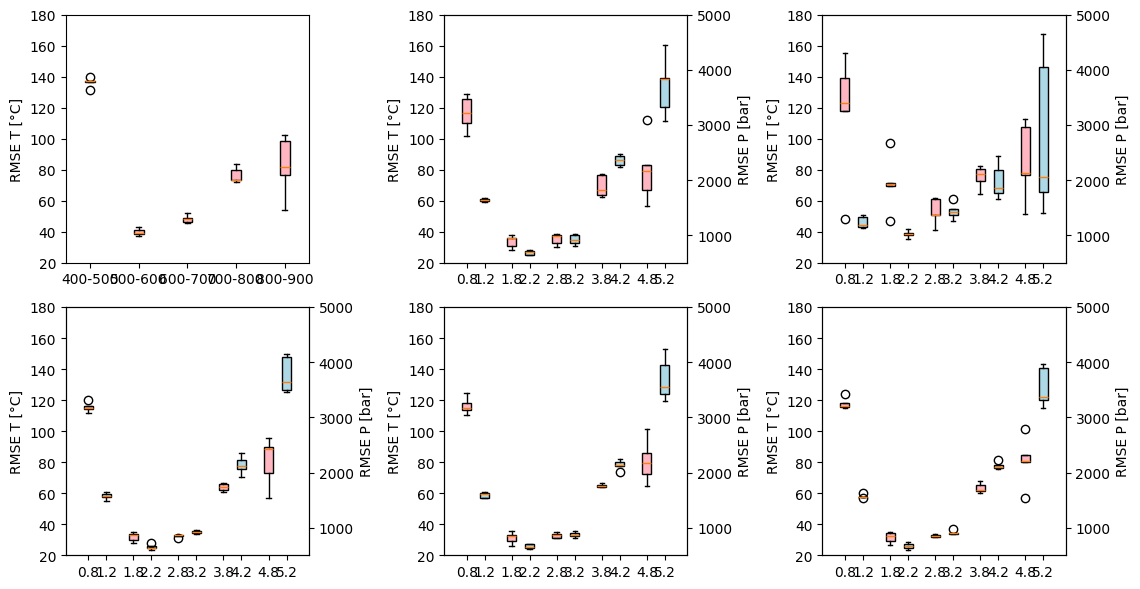

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(11.5, 6))

t_bplot = axs[0, 0].boxplot(np.array(RMSE_temperature_ranges(val_t_TiXMg, y_pred_TiXMg)), positions=[0.8, 1.8, 2.8, 3.8, 4.8], showfliers=True, widths=0.2, patch_artist=True)
axs[0, 0].set_xticklabels(["400-500", "500-600", "600-700", "700-800", "800-900"])

for box in t_bplot["boxes"]:
    box.set_facecolor("lightpink")

t_bplot = axs[0, 1].boxplot(np.array(RMSE_ranges(val_pt_MnFMAST, y_pred_MnFMAST)[1]), positions=[0.8, 1.8, 2.8, 3.8, 4.8], showfliers=True, widths=0.2, patch_artist=True)
twax1 = axs[0, 1].twinx()
p_bplot = twax1.boxplot(np.array(RMSE_ranges(val_pt_MnFMAST, y_pred_MnFMAST)[0]), positions=[1.2, 2.2, 3.2, 4.2, 5.2], showfliers=True, widths=0.2, patch_artist=True)

for box in t_bplot["boxes"]:
    box.set_facecolor("lightpink")

for box in p_bplot["boxes"]:
    box.set_facecolor("lightblue")

t_bplot = axs[0, 2].boxplot(np.array(RMSE_ranges(val_pt_MnFMAST_index, y_pred_MnFMAST_index)[1]), positions=[0.8, 1.8, 2.8, 3.8, 4.8], showfliers=True, widths=0.2, patch_artist=True)
twax2 = axs[0, 2].twinx()
p_bplot = twax2.boxplot(np.array(RMSE_ranges(val_pt_MnFMAST_index, y_pred_MnFMAST_index)[0]), positions=[1.2, 2.2, 3.2, 4.2, 5.2], showfliers=True, widths=0.2, patch_artist=True)

for box in t_bplot["boxes"]:
    box.set_facecolor("lightpink")

for box in p_bplot["boxes"]:
    box.set_facecolor("lightblue")

t_bplot = axs[1, 0].boxplot(np.array(RMSE_ranges(val_pt_MnFMAST, y_pred_ds62_transfer)[1]), positions=[0.8, 1.8, 2.8, 3.8, 4.8], showfliers=True, widths=0.2, patch_artist=True)
twax3 = axs[1, 0].twinx()
p_bplot = twax3.boxplot(np.array(RMSE_ranges(val_pt_MnFMAST, y_pred_ds62_transfer)[0]), positions=[1.2, 2.2, 3.2, 4.2, 5.2], showfliers=True, widths=0.2, patch_artist=True)

for box in t_bplot["boxes"]:
    box.set_facecolor("lightpink")

for box in p_bplot["boxes"]:
    box.set_facecolor("lightblue")

t_bplot = axs[1, 1].boxplot(np.array(RMSE_ranges(val_pt_MnFMAST, y_pred_ds55Bt07_transfer)[1]), positions=[0.8, 1.8, 2.8, 3.8, 4.8], showfliers=True, widths=0.2, patch_artist=True)
twax4 = axs[1, 1].twinx()
p_bplot = twax4.boxplot(np.array(RMSE_ranges(val_pt_MnFMAST, y_pred_ds55Bt07_transfer)[0]), positions=[1.2, 2.2, 3.2, 4.2, 5.2], showfliers=True, widths=0.2, patch_artist=True)

for box in t_bplot["boxes"]:
    box.set_facecolor("lightpink")

for box in p_bplot["boxes"]:
    box.set_facecolor("lightblue")

t_bplot = axs[1, 2].boxplot(np.array(RMSE_ranges(val_pt_MnFMAST, y_pred_ds55BtT_transfer)[1]), positions=[0.8, 1.8, 2.8, 3.8, 4.8], showfliers=True, widths=0.2, patch_artist=True)
twax5 = axs[1, 2].twinx()
p_bplot = twax5.boxplot(np.array(RMSE_ranges(val_pt_MnFMAST, y_pred_ds55BtT_transfer)[0]), positions=[1.2, 2.2, 3.2, 4.2, 5.2], showfliers=True, widths=0.2, patch_artist=True)

for box in t_bplot["boxes"]:
    box.set_facecolor("lightpink")

for box in p_bplot["boxes"]:
    box.set_facecolor("lightblue")

axs[0, 0].set_ylim(20, 180)
axs[0, 0].set_ylabel("RMSE T [°C]")

axs[0, 1].set_ylim(20, 180)
twax1.set_ylim(500, 5000)
axs[0, 1].set_ylabel("RMSE T [°C]")
twax1.set_ylabel("RMSE P [bar]")

axs[0, 2].set_ylim(20, 180)
twax2.set_ylim(500, 5000)
axs[0, 2].set_ylabel("RMSE T [°C]")
twax2.set_ylabel("RMSE P [bar]")

axs[1, 0].set_ylim(20, 180)
twax3.set_ylim(500, 5000)
axs[1, 0].set_ylabel("RMSE T [°C]")
twax3.set_ylabel("RMSE P [bar]")

axs[1, 1].set_ylim(20, 180)
twax4.set_ylim(500, 5000)
axs[1, 1].set_ylabel("RMSE T [°C]")
twax4.set_ylabel("RMSE P [bar]")

axs[1, 2].set_ylim(20, 180)
twax5.set_ylim(500, 5000)
axs[1, 2].set_ylabel("RMSE T [°C]")
twax5.set_ylabel("RMSE P [bar]")

fig.tight_layout()
# fig.savefig("RMSE_T_P_bins.pdf", dpi=600)